In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime as dt

from data_extraction import *
from sklearn import linear_model

In [2]:
df = get_cleaned_dataset()

You are requesting page 1 of your activities data ...
You are requesting page 2 of your activities data ...


In [3]:
distance_in_miles = list(map(meters_to_miles, df["distance"].tolist()))
df["distance"] = distance_in_miles

In [4]:
sec_to_min = lambda s: s/60
time_in_min = list(map(sec_to_min, df["moving_time"]))
avg_pace = [time / dist for time, dist in zip(time_in_min, distance_in_miles)]
df["average_pace"] = avg_pace 

In [5]:
df.columns


Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'athlete.id',
       'athlete.resource_state', 'map.id', 'map.summary_polyline',
       'map.resource_state', 'average_cadence', 'suffer_score',
       'average_pace'],
      dtype='object')

In [6]:
df['date'] = pd.to_datetime(df['start_date_local']).dt.date

In [7]:
x = [dt.datetime.strptime(d[:10], '%Y-%m-%d').date() for d in df["start_date_local"]]

In [8]:
# Fall 23 average trend 


start_date_f23 = "2023-09-01"
end_date_f23 = "2023-12-15"

df_f23 = df[(df["date"] > dt.datetime.strptime(start_date_f23, "%Y-%m-%d").date()) & (df["date"] < dt.datetime.strptime(end_date_f23, "%Y-%m-%d").date())]

fall_2023_pace = df_f23["average_pace"].tolist()[::-1]

days_count_list = [
    (date - dt.datetime.strptime(start_date_f23, "%Y-%m-%d").date()).days for date in df_f23["date"].tolist()[::-1]
]

reg = linear_model.LinearRegression()
y_train = np.array(fall_2023_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace_f23 = reg.predict(X_train.reshape(-1, 1))

In [9]:
# Spring 24 average trend 

start_date_s24 = "2024-01-01"
end_date_s24 = "2024-05-06"

df_s24 = df[(df["date"] > dt.datetime.strptime(start_date_s24, "%Y-%m-%d").date()) & (df["date"] < dt.datetime.strptime(end_date_s24, "%Y-%m-%d").date())]

spring_2024_pace = df_s24["average_pace"].tolist()[::-1]

days_count_list = [
    (date - dt.datetime.strptime(start_date_s24, "%Y-%m-%d").date()).days for date in df_s24["date"].tolist()[::-1]
]

reg = linear_model.LinearRegression()
y_train = np.array(spring_2024_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace_s24 = reg.predict(X_train.reshape(-1, 1))

In [10]:
# Summer 24 average trend 

start_date_su24 = "2024-05-10"
end_date_su24 = "2024-08-30"

df_su24 = df[(df["date"] > dt.datetime.strptime(start_date_su24, "%Y-%m-%d").date()) & (df["date"] < dt.datetime.strptime(end_date_su24, "%Y-%m-%d").date())]

summer_2024_pace = df_su24["average_pace"].tolist()[::-1]

days_count_list = [
    (date - dt.datetime.strptime(start_date_su24, "%Y-%m-%d").date()).days for date in df_su24["date"].tolist()[::-1]
]

reg = linear_model.LinearRegression()
y_train = np.array(summer_2024_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace_su24 = reg.predict(X_train.reshape(-1, 1))

In [15]:
# Fall 24 average trend 

start_date_f24 = "2024-09-01"
end_date_f24 = "2024-12-15"

df_f24 = df[(df["date"] > dt.datetime.strptime(start_date_f24, "%Y-%m-%d").date()) & (df["date"] < dt.datetime.strptime(end_date_f24, "%Y-%m-%d").date())]

fall_2024_pace = df_f24["average_pace"].tolist()[::-1]

days_count_list = [
    (date - dt.datetime.strptime(start_date_f24, "%Y-%m-%d").date()).days for date in df_f24["date"].tolist()[::-1]
]

reg = linear_model.LinearRegression()
y_train = np.array(fall_2024_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace_f24 = reg.predict(X_train.reshape(-1, 1))

In [11]:
list_of_gears = df["gear_id"].unique().tolist()
color_choices = ['green', 'violet', 'r', 'orange', 'k', 'blue']

color_list = [color_choices[list_of_gears.index(id)] for id in df["gear_id"] if id]

scale_list = (df["distance"]*30).tolist()

In [12]:
# get gear information
gear_info_dict = get_gear_info(list_of_gears)
shoe_names_list = [gear_info_dict[id]['name'] for id in gear_info_dict if id]

In [13]:
shoe_names_list

['Brooks Ghost Max 2',
 'HOKA Clifton 9',
 'New Balance 1080v12',
 'Nike Winflo 10',
 'AllBirds Tree Dasher 2']

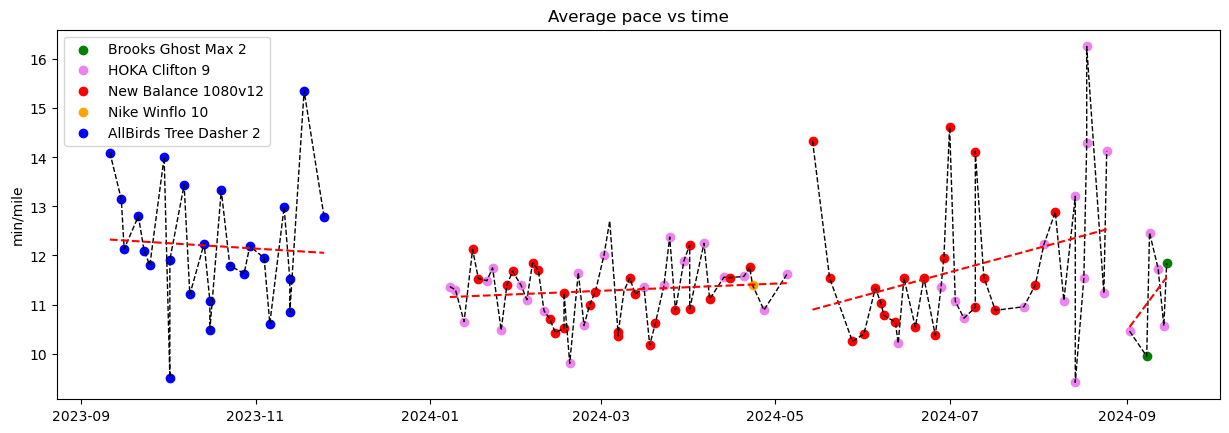

In [19]:
fig, axs = plt.subplots(1) 
fig.set_figwidth(15)

# Fall 23
axs.plot(df_f23["date"].tolist()[::-1], df_f23["average_pace"].tolist()[::-1], linestyle='--', linewidth=1.0, c='k')

for i, id in enumerate(list_of_gears):
    if id:
        x_data = df_f23[df_f23["gear_id"] == id]["date"].tolist()[::-1]
        y_data = df_f23[df_f23["gear_id"] == id]["average_pace"].tolist()[::-1]
        axs.scatter(x_data, y_data, c=color_choices[i], label="{}".format(gear_info_dict[id]["name"]))

axs.plot(df_f23["date"].tolist()[::-1], pred_pace_f23, linestyle="--", c='r')

# Spring 24
axs.plot(df_s24["date"].tolist()[::-1], df_s24["average_pace"].tolist()[::-1], linestyle='--', linewidth=1.0, c='k')

for i, id in enumerate(list_of_gears):
    if id:
        x_data = df_s24[df_s24["gear_id"] == id]["date"].tolist()[::-1]
        y_data = df_s24[df_s24["gear_id"] == id]["average_pace"].tolist()[::-1]
        axs.scatter(x_data, y_data, c=color_choices[i])

axs.plot(df_s24["date"].tolist()[::-1], pred_pace_s24, linestyle="--", c='r')

# Summer 24
axs.plot(df_su24["date"].tolist()[::-1], df_su24["average_pace"].tolist()[::-1], linestyle='--', linewidth=1.0, c='k')

for i, id in enumerate(list_of_gears):
    if id:
        x_data = df_su24[df_su24["gear_id"] == id]["date"].tolist()[::-1]
        y_data = df_su24[df_su24["gear_id"] == id]["average_pace"].tolist()[::-1]
        axs.scatter(x_data, y_data, c=color_choices[i])

axs.plot(df_su24["date"].tolist()[::-1], pred_pace_su24, linestyle="--", c='r')

# Fall 24
axs.plot(df_f24["date"].tolist()[::-1], df_f24["average_pace"].tolist()[::-1], linestyle='--', linewidth=1.0, c='k')

for i, id in enumerate(list_of_gears):
    if id:
        x_data = df_f24[df_f24["gear_id"] == id]["date"].tolist()[::-1]
        y_data = df_f24[df_f24["gear_id"] == id]["average_pace"].tolist()[::-1]
        axs.scatter(x_data, y_data, c=color_choices[i])

axs.plot(df_f24["date"].tolist()[::-1], pred_pace_f24, linestyle="--", c='r')

    

_ = axs.set_ylabel("min/mile")
_ = axs.set_title("Average pace vs time")
_ = plt.legend()

Text(0, 0.5, 'Av Pace (min/mile)')

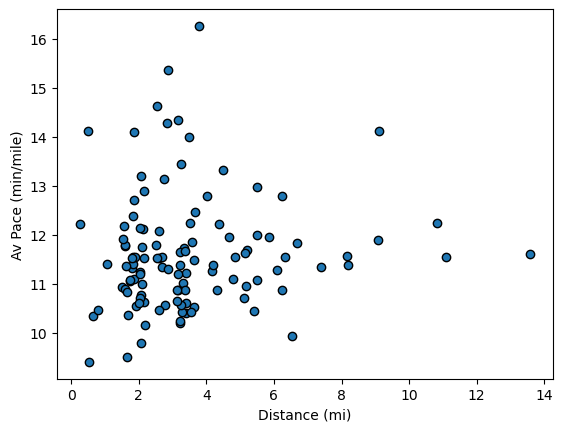

In [37]:
fig, axs = plt.subplots(1) 

df_post_su23 = df[df["date"] > dt.datetime.strptime("2023-08-15", "%Y-%m-%d").date()]

axs.scatter(df_post_su23["distance"], df_post_su23["average_pace"], edgecolor='k')

axs.set_xlabel("Distance (mi)")
axs.set_ylabel("Av Pace (min/mile)")

In [32]:
mean_per_shoe = dict()
std_per_shoe = dict()

for id in list_of_gears:
    if id: 
        av_pace_per_shoe = [df["average_pace"].tolist()[j] for j in range(len(df)) if df["gear_id"].tolist()[j] == id]
        mean_per_shoe[id] = np.mean(av_pace_per_shoe)
        std_per_shoe[id] = np.std(av_pace_per_shoe)

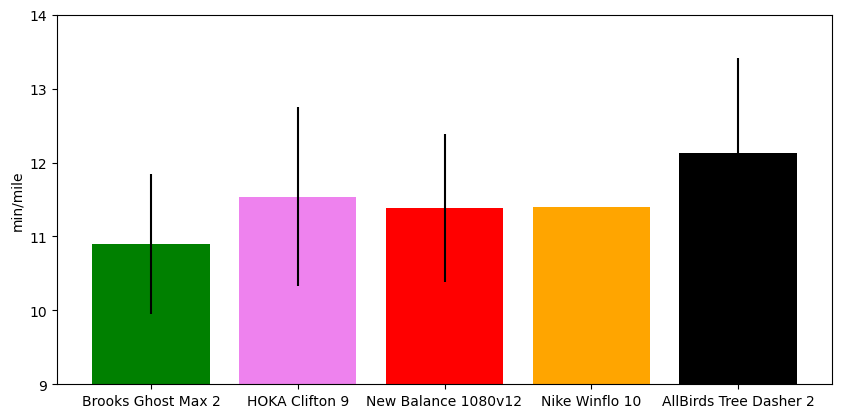

In [36]:
fig, axs = plt.subplots(1)

fig.set_figwidth(10)

axs.bar([1, 2, 3, 4, 5], mean_per_shoe.values(), yerr=std_per_shoe.values(), color=color_choices)
axs.set_xticks([1, 2, 3, 4, 5])
axs.set_ybound([9,14])
_ = axs.set_xticklabels(shoe_names_list)
_ = axs.set_ylabel("min/mile")